In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose

processed_data_dir = "/Users/emre/Desktop/ai_da_jamk/currentai/data/processed"

processed_files = [f for f in os.listdir(processed_data_dir) if f.endswith('.csv')]

processed_data = {}

for file_name in processed_files:
    file_path = os.path.join(processed_data_dir, file_name)
    key = file_name.replace('.csv', '')
    processed_data[key] = pd.read_csv(file_path)

# Assign each dataframe from the dictionary
cleaned_daily_data = processed_data['cleaned_daily_data']
cleaned_acorn_details = processed_data['cleaned_acorn_details']
household_info_processed = processed_data['household_info_processed']
cleaned_weather_daily = processed_data['cleaned_weather_daily']
cleaned_household_info = processed_data['cleaned_household_info']
cleaned_halfhourly_data = processed_data['cleaned_halfhourly_data']
cleaned_hhblock_data = processed_data['cleaned_hhblock_data']
cleaned_weather_hourly = processed_data['cleaned_weather_hourly']
cleaned_uk_bank_holidays = processed_data['cleaned_uk_bank_holidays']

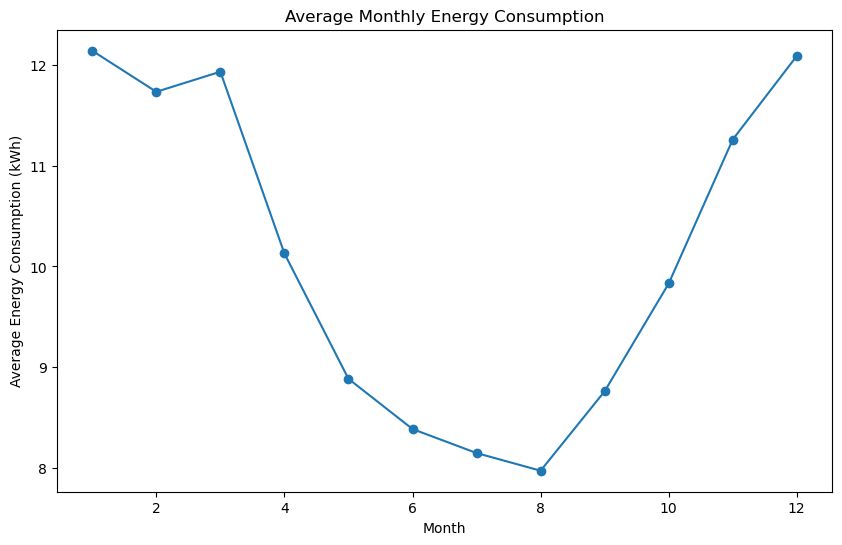

In [4]:
# Key Point 1: Aggregating daily data for seasonality analysis
cleaned_daily_data['day'] = pd.to_datetime(cleaned_daily_data['day'])
cleaned_daily_data['month'] = cleaned_daily_data['day'].dt.month
monthly_energy = cleaned_daily_data.groupby('month')['energy_sum'].mean()

plt.figure(figsize=(10, 6))
plt.plot(monthly_energy.index, monthly_energy.values, marker='o')
plt.title("Average Monthly Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Average Energy Consumption (kWh)")
plt.show()

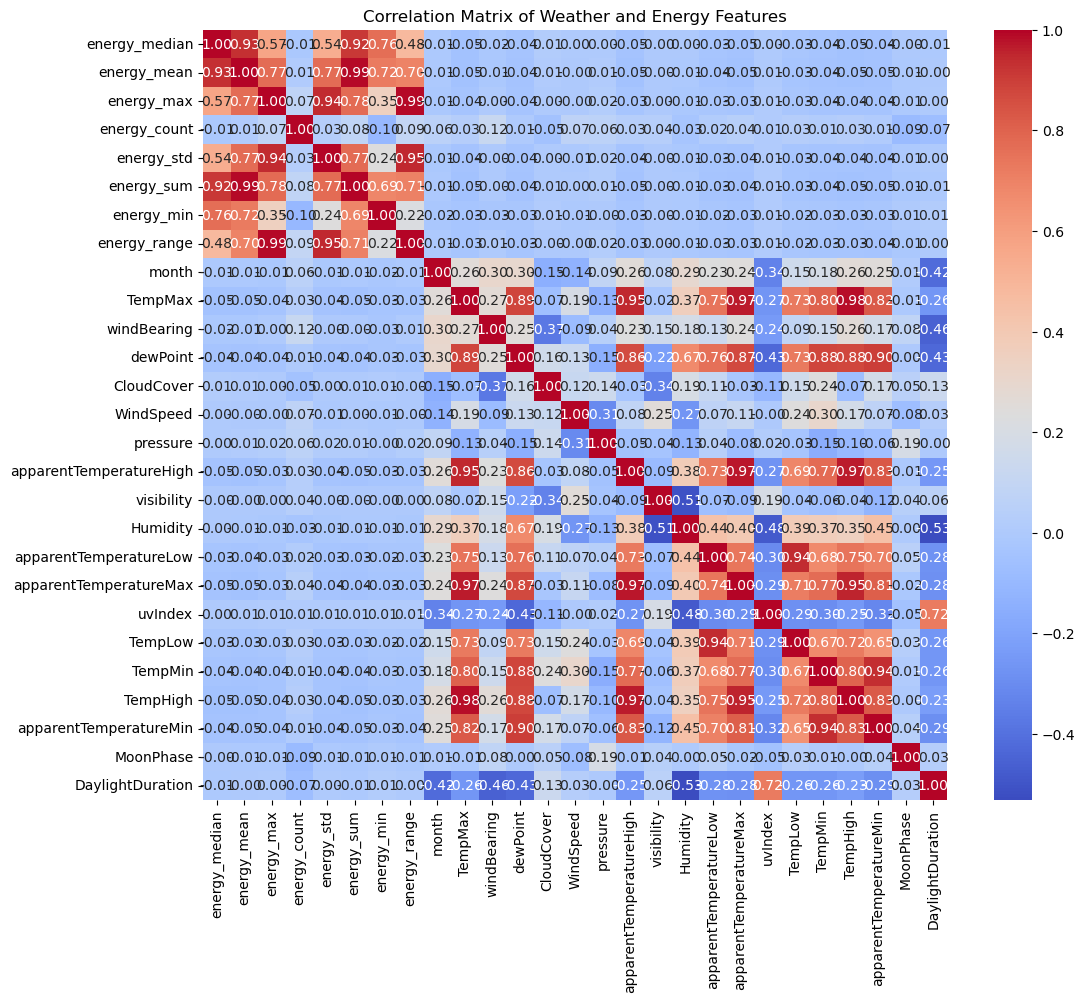

In [7]:
# Key Point 2: Correlation matrix for weather and energy
cleaned_weather_daily['Date'] = pd.to_datetime(cleaned_weather_daily['Date'])
merged_data = cleaned_daily_data.merge(cleaned_weather_daily, left_on='day', right_on='Date')

# Select only numeric columns for correlation matrix
numeric_cols = merged_data.select_dtypes(include=['number']).columns
corr_matrix = merged_data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Weather and Energy Features")
plt.show()



In [8]:
# Key Point 3: Multicollinearity handling using PCA
weather_features = ['TempMax', 'dewPoint', 'CloudCover', 'WindSpeed', 'Humidity']
scaler = StandardScaler()
weather_scaled = scaler.fit_transform(merged_data[weather_features])

pca = PCA(n_components=2)
weather_pca = pca.fit_transform(weather_scaled)
merged_data['Weather_PC1'] = weather_pca[:, 0]
merged_data['Weather_PC2'] = weather_pca[:, 1]

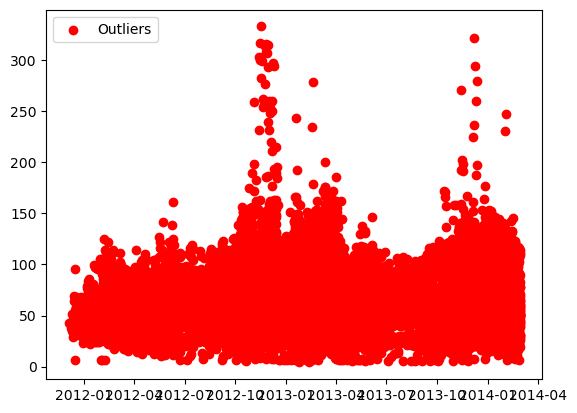

In [9]:
# Key Point 4: Outlier detection using Isolation Forest
iso = IsolationForest(contamination=0.01)
outliers = iso.fit_predict(cleaned_daily_data[['energy_sum', 'energy_range']])
cleaned_daily_data['outlier'] = outliers

outliers_df = cleaned_daily_data[cleaned_daily_data['outlier'] == -1]
plt.scatter(outliers_df['day'], outliers_df['energy_sum'], color='red', label='Outliers')
plt.legend()
plt.show()

In [13]:
household_info_encoded = pd.get_dummies(cleaned_household_info[['stdorToU', 'Acorn_grouped']], drop_first=True)
merged_data = merged_data.merge(household_info_encoded, left_on='LCLid', right_on='LCLid', how='left')

# Key Point 6: Creating lagged features for time series modeling
for lag in range(1, 4):
    cleaned_daily_data[f'lag_{lag}'] = cleaned_daily_data['energy_sum'].shift(lag)

# Key Point 7: Time series decomposition for seasonality
cleaned_daily_data.set_index('day', inplace=True)
decomposition = seasonal_decompose(cleaned_daily_data['energy_sum'], model='additive', period=365)
decomposition.plot()
plt.show()

KeyError: 'LCLid'

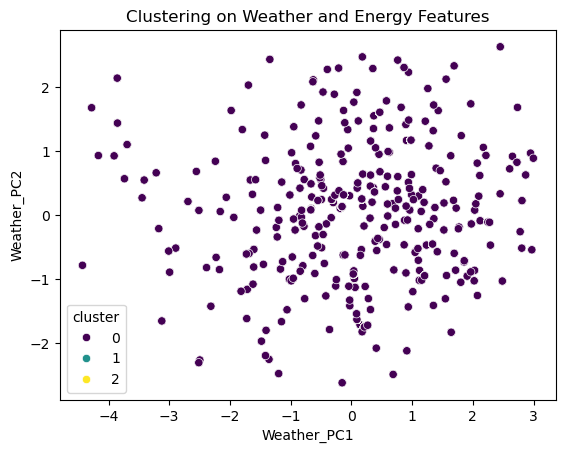

In [14]:
# Key Point 8: Clustering analysis for energy consumption patterns
clustering_features = ['energy_sum', 'energy_range', 'Weather_PC1', 'Weather_PC2']
kmeans = KMeans(n_clusters=3, random_state=42)
merged_data['cluster'] = kmeans.fit_predict(merged_data[clustering_features])

sns.scatterplot(data=merged_data, x='Weather_PC1', y='Weather_PC2', hue='cluster', palette='viridis')
plt.title("Clustering on Weather and Energy Features")
plt.show()

In [17]:
# Key Point 9: Visualizing energy consumption by ACORN categories
acorn_energy = merged_data.groupby('Acorn_grouped')['energy_sum'].mean()
acorn_energy.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title("Average Energy Consumption by ACORN Group")
plt.xlabel("ACORN Group")
plt.ylabel("Average Energy Consumption (kWh)")
plt.show()

KeyError: 'Acorn_grouped'